In [88]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import os
import os
import torch
import pandas as pd
from torch.utils.data import Dataset
import numpy as np
from sklearn.metrics import accuracy_score
import tqdm
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

In [89]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cpu')

In [90]:
train_dir = '..\\preprocessed data\\train'
val_dir = '..\\preprocessed data\\val'
test_dir = '..\\preprocessed data\\test\\X.csv'

In [91]:
class CustomDataset(Dataset):
    def __init__(self, train_dir: str, augment : bool =False, noise_factor : float =0.1):
        """
        Args:
            train_dir (string): Directory with 'X.csv' and 'targets.csv' files.
            augment (bool): Whether to apply augmentation.
            noise_factor (float): Factor to control the amount of noise added for augmentation.
        """
        # Construct file paths
        data_path = os.path.join(train_dir, "X.csv")
        target_path = os.path.join(train_dir, "targets.csv")
        
        # Load the data and targets from csv files
        self.data = pd.read_csv(data_path)
        self.targets = pd.read_csv(target_path)
        
        # Ensure the data and targets have matching lengths
        assert len(self.data) == len(self.targets), "Data and targets must have the same length"
        
        # Augmentation parameters
        self.augment = augment
        self.noise_factor = noise_factor
        
    def __len__(self):
        # Return the total number of samples
        return len(self.data)
    
    def __getitem__(self, idx):
        # Get the features and target for the given index
        data_sample = self.data.iloc[idx].values
        target_sample = self.targets.iloc[idx].values
        
        # Apply augmentation if specified
        if self.augment:
            data_sample = self._augment_data(data_sample)
        
        # Convert to torch tensors
        data_sample = torch.tensor(data_sample, dtype=torch.float32)
        target_sample = torch.tensor(target_sample, dtype=torch.float32)
        
        return data_sample, target_sample
    
    def _augment_data(self, data_sample):
        # Add random noise to the data sample
        np.random.seed(42)
        noise = np.random.normal(0, self.noise_factor, data_sample.shape)
        augmented_data = data_sample + noise
        return augmented_data

In [92]:
train_dataset = CustomDataset(train_dir=train_dir,)
val_dataset = CustomDataset(train_dir = val_dir,)

In [93]:
train_dataset.data

,Age,Height,Weight,FCVC,NCP,CH2O,FAF,TUE,Gender_Female,Gender_Male,...,SCC_yes,CALC_Always,CALC_Frequently,CALC_Sometimes,CALC_no,MTRANS_Automobile,MTRANS_Bike,MTRANS_Motorbike,MTRANS_Public_Transportation,MTRANS_Walking
0,0.115632,0.138434,0.022388,1.000000,0.000000,0.298106,0.000000,0.280444,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.148936,0.377358,0.231343,0.500000,0.000000,1.000000,0.333333,0.000000,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.180199,0.435581,0.320896,0.110012,0.000000,0.500000,0.000000,0.610015,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.205275,0.401845,0.563280,1.000000,0.666667,0.659368,0.116280,0.206403,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.153349,0.471698,0.323351,0.498319,0.666667,0.837784,0.000000,0.845051,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18290,0.170213,0.566038,0.417910,1.000000,0.666667,0.500000,1.000000,0.000000,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
18291,0.185963,0.504317,0.275733,0.500000,0.666667,0.500000,0.000000,1.000000,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
18292,0.148936,0.320755,0.216418,0.500000,0.666667,1.000000,0.666667,0.000000,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
18293,0.255319,0.377594,0.544326,1.000000,0.666667,0.885366,0.000000,0.118653,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [94]:
train_dataset.targets

,0
0,0
1,5
2,2
3,4
4,6
...,...
18290,6
18291,5
18292,5
18293,4


In [95]:
BATCH_SIZE = 32
# NUM_WORKERS = os.cpu_count()
train_dl = DataLoader(
    train_dataset ,
    shuffle = False ,
    batch_size=BATCH_SIZE,
)

val_dl = DataLoader(
    val_dataset , 
    shuffle = False ,
    batch_size=BATCH_SIZE,
)

In [96]:
for _, batch in enumerate(train_dl):
    X , y = batch[0] , batch[1]
    print(X.shape, y.shape)
    break

torch.Size([32, 31]) torch.Size([32, 1])


In [97]:
class NeuralNetworkV1(nn.Module):
    def __init__(self, in_features , num_classes):
        super(NeuralNetworkV1, self).__init__()

        self.LinearBlock1 = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=in_features, out_features=32),
            nn.BatchNorm1d(32),
            nn.LeakyReLU(0.2, inplace=True)
        )

        self.LinearBlock2 = nn.Sequential(
            nn.Linear(in_features=32, out_features=32),
            nn.BatchNorm1d(32),
            nn.LeakyReLU(0.2, inplace=True)
        )

        self.LinearBlock3 = nn.Sequential(
            nn.Linear(in_features=32, out_features=64),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(0.2, inplace=True)
        )

        self.FC = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(in_features=64, out_features=num_classes),
            nn.LeakyReLU(0.2, inplace=True),
        )

    def forward(self, x):
        x = self.LinearBlock1(x)
        x = self.LinearBlock2(x)
        x = self.LinearBlock3(x)
        x = self.FC(x)
        return x

model = NeuralNetworkV1(in_features=31 , num_classes=7).to(device)
model

NeuralNetworkV1(
  (LinearBlock1): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=31, out_features=32, bias=True)
    (2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (LinearBlock2): Sequential(
    (0): Linear(in_features=32, out_features=32, bias=True)
    (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (LinearBlock3): Sequential(
    (0): Linear(in_features=32, out_features=64, bias=True)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (FC): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=64, out_features=7, bias=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
)

In [98]:
import torch
from sklearn.metrics import accuracy_score

def train_step(model: torch.nn.Module,
               train_dl: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device) -> tuple[float, float]:

    model.to(device)
    model.train()

    train_accuracy = 0.0
    train_loss = 0.0

    for idx, (X_train, train_targets) in enumerate(train_dl):

        X_train, train_targets = X_train.to(device), train_targets.to(device)

        # Ensure targets are of type LongTensor
        train_targets = train_targets.long()

        train_logits = model(X_train)
        train_preds = torch.softmax(train_logits, dim=1).argmax(dim=1)

        # Compute loss
        loss = loss_fn(train_logits, train_targets.squeeze(1))

        # Calculate accuracy
        train_acc = accuracy_score(train_targets.cpu(), train_preds.cpu())

        train_accuracy += train_acc
        train_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_accuracy /= len(train_dl)
    train_loss /= len(train_dl)

    return train_accuracy, train_loss

In [99]:
def eval_step(model: torch.nn.Module,
              val_dl: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device: torch.device) -> tuple[float, float]:


    val_accuracy = 0.0
    val_loss = 0.0

    model.to(device)
    model.eval()

    with torch.inference_mode():

        for X_val, val_targets in val_dl:
            X_val, val_targets = X_val.to(device), val_targets.to(device)
            
            val_targets = val_targets.long()
            
            val_logits = model(X_val)
            val_loss = loss_fn(val_logits, val_targets.squeeze(dim=1))

            val_preds = torch.softmax(val_logits,dim=1).argmax(dim=1).unsqueeze(1)
            val_acc = accuracy_score(val_targets.flatten() , val_preds.flatten())

            val_accuracy += val_acc
            val_loss += val_loss.item()

        val_accuracy /= len(val_dl)
        val_loss /= len(val_dl)

    return val_accuracy, val_loss

In [100]:
def train_model(model : torch.nn.Module,
               train_dl : torch.utils.data.DataLoader,
               val_dl : torch.utils.data.DataLoader,
               loss_fn : torch.nn.Module,
               optimizer : torch.optim.Optimizer,
               epochs: int,
               device : torch.device) -> dict[str, list[float]]:
    

    results = {"train_accuracy": [],
        "train_loss": [],
        "val_accuracy": [],
        "val_loss": [],
    }
    
    for epoch in tqdm(range(epochs)):
        
        train_accuracy , train_loss =train_step(train_dl=train_dl, 
            model=model, 
            loss_fn=loss_fn,
            optimizer=optimizer,
            device = device
        )

        val_accuracy , val_loss =eval_step(
            model=model,
            val_dl= val_dl,
            loss_fn=loss_fn,
            device = device
        )

        results['train_accuracy'].append(train_accuracy)
        results['train_loss'].append(train_loss)
        results['val_accuracy'].append(val_accuracy)
        results['val_loss'].append(val_loss)

        print('-------------- EPOCH {} ----------------------------'.format(epoch))
        print(f"Train Accuracy: {train_accuracy:.5f} | Train Loss : {train_loss:.5f}")
        print(f"Val Accuracy: {val_accuracy:.5f} | Val Loss: {val_loss:.5f}\n")
        print()

    return results

In [101]:
import torch.optim as optim 

epochs = 40
learning_rate = 0.0001

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate )

model_history = train_model(model=model,
                    train_dl=train_dl,
                    val_dl=val_dl,
                    optimizer=optimizer, 
                    loss_fn=loss_fn,
                    epochs = epochs, 
                    device=device)

  2%|▎         | 1/40 [00:03<02:08,  3.30s/it]

-------------- EPOCH 0 ----------------------------
Train Accuracy: 0.44217 | Train Loss : 1.58289
Val Accuracy: 0.56649 | Val Loss: 0.01504




  5%|▌         | 2/40 [00:06<02:05,  3.31s/it]

-------------- EPOCH 1 ----------------------------
Train Accuracy: 0.56121 | Train Loss : 1.23346
Val Accuracy: 0.62335 | Val Loss: 0.01169




  8%|▊         | 3/40 [00:09<02:03,  3.33s/it]

-------------- EPOCH 2 ----------------------------
Train Accuracy: 0.61758 | Train Loss : 1.05666
Val Accuracy: 0.68370 | Val Loss: 0.01014




 10%|█         | 4/40 [00:13<02:04,  3.46s/it]

-------------- EPOCH 3 ----------------------------
Train Accuracy: 0.65369 | Train Loss : 0.93358
Val Accuracy: 0.71145 | Val Loss: 0.00917




 12%|█▎        | 5/40 [00:17<02:07,  3.64s/it]

-------------- EPOCH 4 ----------------------------
Train Accuracy: 0.68404 | Train Loss : 0.85041
Val Accuracy: 0.74117 | Val Loss: 0.00842




 15%|█▌        | 6/40 [00:21<02:06,  3.71s/it]

-------------- EPOCH 5 ----------------------------
Train Accuracy: 0.70590 | Train Loss : 0.78546
Val Accuracy: 0.76171 | Val Loss: 0.00774




 18%|█▊        | 7/40 [00:26<02:21,  4.28s/it]

-------------- EPOCH 6 ----------------------------
Train Accuracy: 0.72250 | Train Loss : 0.73635
Val Accuracy: 0.78224 | Val Loss: 0.00718




 20%|██        | 8/40 [00:31<02:18,  4.33s/it]

-------------- EPOCH 7 ----------------------------
Train Accuracy: 0.74025 | Train Loss : 0.68886
Val Accuracy: 0.79952 | Val Loss: 0.00670




 22%|██▎       | 9/40 [00:35<02:16,  4.40s/it]

-------------- EPOCH 8 ----------------------------
Train Accuracy: 0.75333 | Train Loss : 0.65406
Val Accuracy: 0.80892 | Val Loss: 0.00635




 25%|██▌       | 10/40 [00:40<02:10,  4.35s/it]

-------------- EPOCH 9 ----------------------------
Train Accuracy: 0.75849 | Train Loss : 0.62562
Val Accuracy: 0.81855 | Val Loss: 0.00599




 28%|██▊       | 11/40 [00:44<02:07,  4.40s/it]

-------------- EPOCH 10 ----------------------------
Train Accuracy: 0.77347 | Train Loss : 0.60585
Val Accuracy: 0.82554 | Val Loss: 0.00576




 30%|███       | 12/40 [00:49<02:05,  4.48s/it]

-------------- EPOCH 11 ----------------------------
Train Accuracy: 0.77646 | Train Loss : 0.59001
Val Accuracy: 0.83013 | Val Loss: 0.00557




 32%|███▎      | 13/40 [00:53<02:02,  4.52s/it]

-------------- EPOCH 12 ----------------------------
Train Accuracy: 0.78083 | Train Loss : 0.57455
Val Accuracy: 0.83277 | Val Loss: 0.00532




 35%|███▌      | 14/40 [00:58<01:55,  4.44s/it]

-------------- EPOCH 13 ----------------------------
Train Accuracy: 0.78521 | Train Loss : 0.56842
Val Accuracy: 0.83495 | Val Loss: 0.00524




 38%|███▊      | 15/40 [01:02<01:49,  4.39s/it]

-------------- EPOCH 14 ----------------------------
Train Accuracy: 0.79022 | Train Loss : 0.55334
Val Accuracy: 0.83802 | Val Loss: 0.00511




 40%|████      | 16/40 [01:06<01:45,  4.38s/it]

-------------- EPOCH 15 ----------------------------
Train Accuracy: 0.79443 | Train Loss : 0.54755
Val Accuracy: 0.84194 | Val Loss: 0.00502




 42%|████▎     | 17/40 [01:11<01:40,  4.36s/it]

-------------- EPOCH 16 ----------------------------
Train Accuracy: 0.79920 | Train Loss : 0.53566
Val Accuracy: 0.84283 | Val Loss: 0.00485




 45%|████▌     | 18/40 [01:15<01:34,  4.31s/it]

-------------- EPOCH 17 ----------------------------
Train Accuracy: 0.80063 | Train Loss : 0.53412
Val Accuracy: 0.84698 | Val Loss: 0.00469




 48%|████▊     | 19/40 [01:19<01:28,  4.22s/it]

-------------- EPOCH 18 ----------------------------
Train Accuracy: 0.79912 | Train Loss : 0.53188
Val Accuracy: 0.84677 | Val Loss: 0.00473




 50%|█████     | 20/40 [01:23<01:24,  4.22s/it]

-------------- EPOCH 19 ----------------------------
Train Accuracy: 0.80336 | Train Loss : 0.51955
Val Accuracy: 0.84567 | Val Loss: 0.00460




 52%|█████▎    | 21/40 [01:27<01:21,  4.29s/it]

-------------- EPOCH 20 ----------------------------
Train Accuracy: 0.80459 | Train Loss : 0.52079
Val Accuracy: 0.84939 | Val Loss: 0.00464




 55%|█████▌    | 22/40 [01:32<01:18,  4.38s/it]

-------------- EPOCH 21 ----------------------------
Train Accuracy: 0.80614 | Train Loss : 0.51525
Val Accuracy: 0.85004 | Val Loss: 0.00454




 57%|█████▊    | 23/40 [01:37<01:15,  4.47s/it]

-------------- EPOCH 22 ----------------------------
Train Accuracy: 0.81094 | Train Loss : 0.50737
Val Accuracy: 0.85092 | Val Loss: 0.00450




 60%|██████    | 24/40 [01:41<01:11,  4.48s/it]

-------------- EPOCH 23 ----------------------------
Train Accuracy: 0.80982 | Train Loss : 0.50352
Val Accuracy: 0.84939 | Val Loss: 0.00454




 62%|██████▎   | 25/40 [01:46<01:07,  4.47s/it]

-------------- EPOCH 24 ----------------------------
Train Accuracy: 0.81224 | Train Loss : 0.50293
Val Accuracy: 0.85332 | Val Loss: 0.00452




 65%|██████▌   | 26/40 [01:50<01:02,  4.47s/it]

-------------- EPOCH 25 ----------------------------
Train Accuracy: 0.81189 | Train Loss : 0.50177
Val Accuracy: 0.85070 | Val Loss: 0.00446




 68%|██████▊   | 27/40 [01:55<00:58,  4.46s/it]

-------------- EPOCH 26 ----------------------------
Train Accuracy: 0.81104 | Train Loss : 0.49991
Val Accuracy: 0.85245 | Val Loss: 0.00441




 70%|███████   | 28/40 [02:00<00:56,  4.71s/it]

-------------- EPOCH 27 ----------------------------
Train Accuracy: 0.81519 | Train Loss : 0.49505
Val Accuracy: 0.85026 | Val Loss: 0.00438




 72%|███████▎  | 29/40 [02:05<00:52,  4.74s/it]

-------------- EPOCH 28 ----------------------------
Train Accuracy: 0.81426 | Train Loss : 0.48797
Val Accuracy: 0.85157 | Val Loss: 0.00443




 75%|███████▌  | 30/40 [02:09<00:47,  4.73s/it]

-------------- EPOCH 29 ----------------------------
Train Accuracy: 0.81645 | Train Loss : 0.48876
Val Accuracy: 0.85048 | Val Loss: 0.00421




 78%|███████▊  | 31/40 [02:14<00:41,  4.65s/it]

-------------- EPOCH 30 ----------------------------
Train Accuracy: 0.81904 | Train Loss : 0.48522
Val Accuracy: 0.85223 | Val Loss: 0.00427




 80%|████████  | 32/40 [02:19<00:37,  4.68s/it]

-------------- EPOCH 31 ----------------------------
Train Accuracy: 0.82149 | Train Loss : 0.48624
Val Accuracy: 0.85135 | Val Loss: 0.00418




 82%|████████▎ | 33/40 [02:23<00:32,  4.63s/it]

-------------- EPOCH 32 ----------------------------
Train Accuracy: 0.81855 | Train Loss : 0.48462
Val Accuracy: 0.85201 | Val Loss: 0.00425




 85%|████████▌ | 34/40 [02:28<00:27,  4.55s/it]

-------------- EPOCH 33 ----------------------------
Train Accuracy: 0.82151 | Train Loss : 0.47945
Val Accuracy: 0.85332 | Val Loss: 0.00426




 88%|████████▊ | 35/40 [02:32<00:22,  4.54s/it]

-------------- EPOCH 34 ----------------------------
Train Accuracy: 0.82202 | Train Loss : 0.47820
Val Accuracy: 0.85551 | Val Loss: 0.00414




 90%|█████████ | 36/40 [02:37<00:18,  4.56s/it]

-------------- EPOCH 35 ----------------------------
Train Accuracy: 0.82426 | Train Loss : 0.47742
Val Accuracy: 0.85529 | Val Loss: 0.00417




 92%|█████████▎| 37/40 [02:41<00:13,  4.58s/it]

-------------- EPOCH 36 ----------------------------
Train Accuracy: 0.82464 | Train Loss : 0.47270
Val Accuracy: 0.85726 | Val Loss: 0.00419




 95%|█████████▌| 38/40 [02:46<00:09,  4.59s/it]

-------------- EPOCH 37 ----------------------------
Train Accuracy: 0.82579 | Train Loss : 0.47177
Val Accuracy: 0.85638 | Val Loss: 0.00422




 98%|█████████▊| 39/40 [02:50<00:04,  4.47s/it]

-------------- EPOCH 38 ----------------------------
Train Accuracy: 0.82568 | Train Loss : 0.47321
Val Accuracy: 0.85769 | Val Loss: 0.00407




100%|██████████| 40/40 [02:54<00:00,  4.37s/it]

-------------- EPOCH 39 ----------------------------
Train Accuracy: 0.82703 | Train Loss : 0.47171
Val Accuracy: 0.85769 | Val Loss: 0.00404




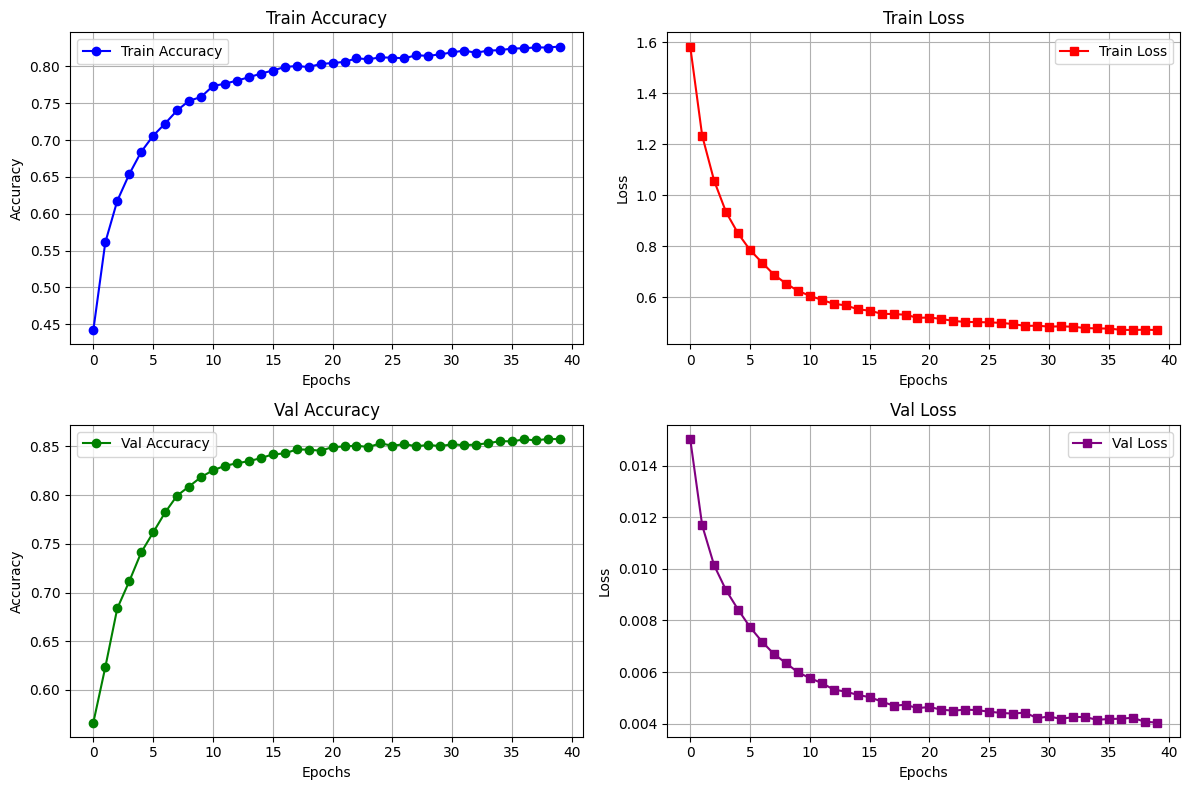

In [103]:
from matplotlib.gridspec import GridSpec
def plot_loss_curve_grid(results: dict[str, list[float]]) -> None:
    """
    Plots training curves of a results dictionary.
    Args:
        results (dict): Dictionary containing lists of values.
            Example:
            {'loss_generator': [float],
             'loss_discriminator': [float],
             'real_scores': [float],
             'fake_scores': [float]}
    Plots:
        - Generator Loss over epochs.
        - Discriminator Loss over epochs.
        - Real Score over epochs.
        - Fake Score over epochs.
    """

    train_accuracy = results['train_accuracy']
    train_loss = results['train_loss']
    val_accuracy = results['val_accuracy']
    val_loss = results['val_loss']

    epochs = range(len(train_accuracy))

    fig = plt.figure(figsize=(12, 8))
    gs = GridSpec(2, 2, figure=fig)

    ax1 = fig.add_subplot(gs[0, 0])
    ax1.plot(epochs, train_accuracy, marker='o', color='b', label='Train Accuracy')
    ax1.set_title('Train Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    ax1.grid(True)

    ax2 = fig.add_subplot(gs[0, 1])
    ax2.plot(epochs, train_loss, marker='s', color='r', label='Train Loss')
    ax2.set_title('Train Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid(True)

    ax3 = fig.add_subplot(gs[1, 0])
    ax3.plot(epochs, val_accuracy, marker='o', color='g', label='Val Accuracy')
    ax3.set_title('Val Accuracy')
    ax3.set_xlabel('Epochs')
    ax3.set_ylabel('Accuracy')
    ax3.legend()
    ax3.grid(True)

    ax4 = fig.add_subplot(gs[1, 1])
    ax4.plot(epochs, val_loss, marker='s', color='purple', label='Val Loss')
    ax4.set_title('Val Loss')
    ax4.set_xlabel('Epochs')
    ax4.set_ylabel('Loss')
    ax4.legend()
    ax4.grid(True)

    plt.tight_layout()
    plt.show()

plot_loss_curve_grid(model_history)

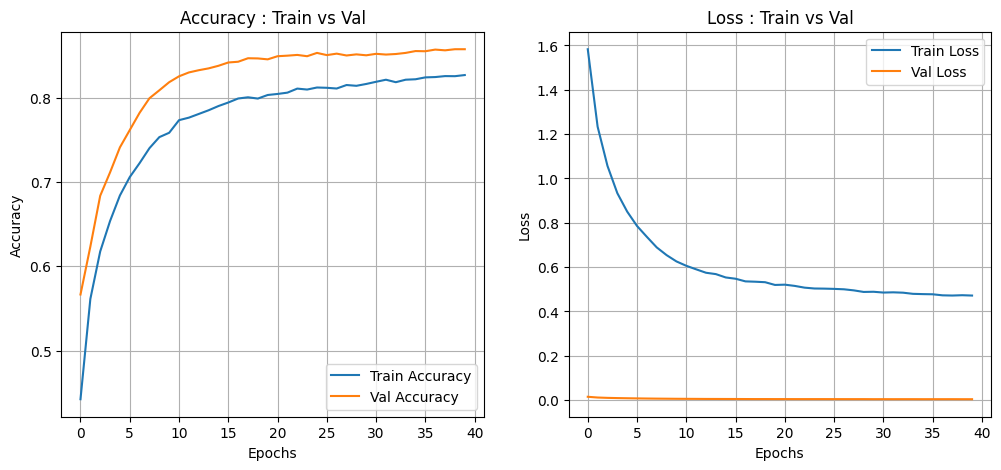

In [104]:
def plot_loss_curves(results: dict[str, list[float]]) -> None:
    """
    Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {'loss_generator' : [],
            'loss_discriminator' : [],
            'real_scores' : [],
            'fake_scores' : [],}
    """
    train_accuracy = results['train_accuracy']
    train_loss = results['train_loss']
    val_accuracy = results['val_accuracy']
    val_loss = results['val_loss']

    epochs = range(len(results['train_accuracy']))

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_accuracy, label='Train Accuracy')
    plt.plot(epochs, val_accuracy, label='Val Accuracy')
    plt.title('Accuracy : Train vs Val')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_loss, label='Train Loss')
    plt.plot(epochs, val_loss, label='Val Loss')
    plt.title('Loss : Train vs Val')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
plot_loss_curves(model_history)

In [105]:
def get_preds(model:torch.nn.Module,
              dataloader : torch.utils.data.DataLoader,
              device : torch.device) -> list[torch.Tensor]:
    """
    Generate predictions using the provided model and data loader.

    Args:
        model (torch.nn.Module): The neural network model used for prediction.
        dataloader (torch.utils.data.DataLoader): DataLoader for the dataset.
        device (torch.device): Device to perform predictions on (e.g., 'cuda' or 'cpu').

    Returns:
        list[torch.Tensor]: A list containing the predictions for each sample in the dataset.
    """

    y_preds = []
    model.eval()
    with torch.inference_mode():
        for X, y in tqdm(dataloader, desc="Making predictions"):

            X, y = X.to(device), y.to(device)
            y = y.long()

            y_logits = model(X)
            y_pred = torch.softmax(y_logits,dim=1).argmax(dim=1)

            y_preds.append(y_pred.cpu())

    y_pred_tensor = torch.cat(y_preds)

    return y_pred_tensor

val_preds = get_preds(model=model , dataloader=val_dl , device=device)
train_preds = get_preds(model=model , dataloader=train_dl , device=device)

Making predictions: 100%|██████████| 572/572 [00:01<00:00, 515.35it/s]


In [106]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

val_targets = [label for X,label  in val_dataset]
print(f'Validation Accuarcy : {accuracy_score(val_targets, val_preds)*100}%')
train_targets = [label for X,label  in train_dataset]
print(f'Validation Accuarcy : {accuracy_score(train_targets, train_preds)*100}%')

Validation Accuarcy : 85.76738084827285%
Validation Accuarcy : 87.23148401202513%


In [107]:
from sklearn.metrics import classification_report
print('------------------------------------------------------------')
val_report = classification_report(val_targets, val_preds)
print(f'Classification Report : Validation Dataset')
print(val_report)
print('------------------------------------------------------------')
print()
train_report = classification_report(train_targets, train_preds)
print(f'Classification Report : Test Dataset')
print(train_report)

------------------------------------------------------------
Classification Report : Validation Dataset
              precision    recall  f1-score   support

         0.0       0.89      0.93      0.91       585
         1.0       0.84      0.76      0.80       667
         2.0       0.86      0.81      0.84       670
         3.0       0.93      0.97      0.95       718
         4.0       1.00      1.00      1.00       845
         5.0       0.70      0.70      0.70       531
         6.0       0.69      0.75      0.72       558

    accuracy                           0.86      4574
   macro avg       0.84      0.85      0.84      4574
weighted avg       0.86      0.86      0.86      4574

------------------------------------------------------------

Classification Report : Test Dataset
              precision    recall  f1-score   support

         0.0       0.89      0.94      0.91      2210
         1.0       0.87      0.79      0.83      2702
         2.0       0.88      0.84    

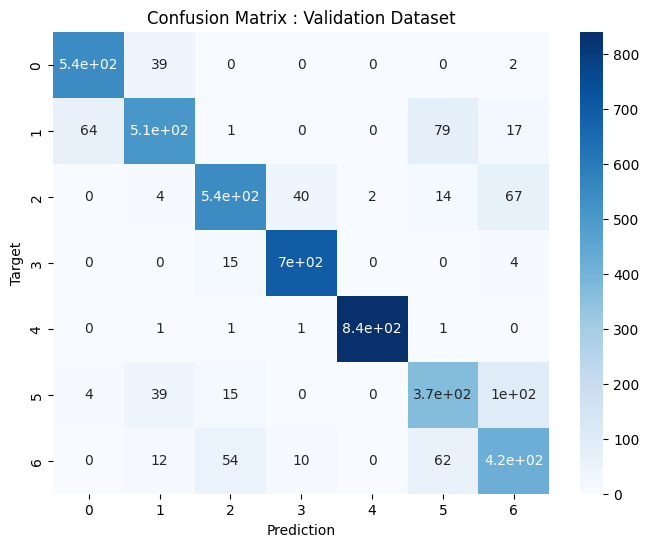

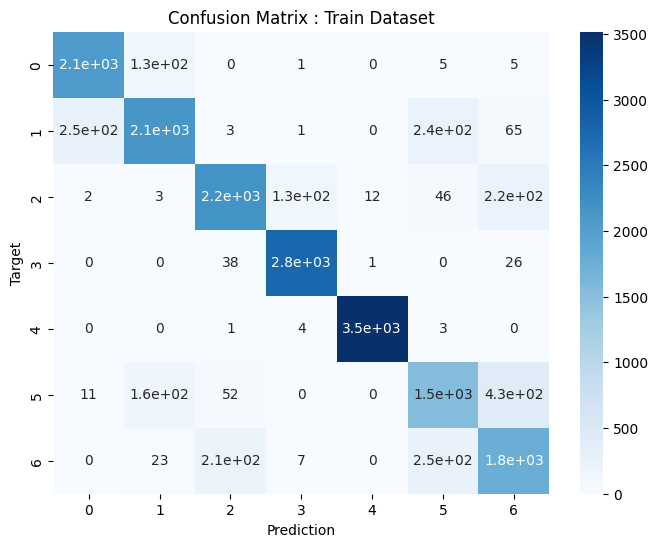

In [108]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
def plot_confusion_matrix(title: str ,targets:torch.Tensor , preds : torch.Tensor):
    cf = confusion_matrix(targets, preds)
    plt.figure(figsize=(8,6))
    sns.heatmap(cf , annot=True , cmap = 'Blues')
    plt.xlabel('Prediction')
    plt.ylabel('Target')
    plt.title(f'Confusion Matrix : {title}') 
    plt.show()
    
plot_confusion_matrix(title = 'Validation Dataset' ,preds = val_preds , targets = val_targets )
plot_confusion_matrix(title = 'Train Dataset' ,preds = train_preds , targets = train_targets )